In [2]:
# Cell 1: Setup and Data Preparation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import nibabel as nib

# Set up directories
study_dir = "/lab_data/behrmannlab/vlad/ptoc"
residual_dir = "/user_data/csimmon2/ptoc_residuals"
results_dir = "/user_data/csimmon2/git_repos/ptoc/results"
curr_dir = "/user_data/csimmon2/git_repos/ptoc"

# Parameters
hemispheres = ['left', 'right']

# Load subjects (excluding sub-084)
sub_info = pd.read_csv(f'{curr_dir}/sub_info.csv')
subjects = [sub for sub in sub_info[sub_info['group'] == 'control']['sub'].tolist() if sub != 'sub-084']

print(f"Setup complete!")
print(f"Subjects: {len(subjects)}")
print(f"Directories configured")

# Define dice coefficient function
def dice_coefficient(img1_data, img2_data):
    """Calculate Dice coefficient - same as throughout analysis"""
    img1_bin = (img1_data > 0).astype(int)
    img2_bin = (img2_data > 0).astype(int)
    intersection = np.sum(img1_bin * img2_bin)
    dice = 2.0 * intersection / (np.sum(img1_bin) + np.sum(img2_bin))
    return dice

print("Functions defined!")
print("Ready for analysis")

Setup complete!
Subjects: 18
Directories configured
Functions defined!
Ready for analysis


In [3]:
# Cell 2: Calculate Within-Subject Independent Overlap
# This calculates pIPS_clean vs LO_clean overlap within the same subjects

print("WITHIN-SUBJECT INDEPENDENT OVERLAP ANALYSIS")
print("="*50)

within_subject_dice = []
within_subject_subjects = []

for sub in subjects:
    try:
        # Load cleaned pIPS data (both hemispheres)
        pips_data = []
        for hemi in hemispheres:
            pips_file = f"{residual_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_pIPS_clean_{hemi}_loc_fc_mni.nii.gz"
            if os.path.exists(pips_file):
                img = nib.load(pips_file)
                pips_data.append(img.get_fdata())
        
        # Load cleaned LO data (both hemispheres)
        lo_data = []
        for hemi in hemispheres:
            lo_file = f"{residual_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_LO_clean_{hemi}_loc_fc_mni.nii.gz"
            if os.path.exists(lo_file):
                img = nib.load(lo_file)
                lo_data.append(img.get_fdata())
        
        # Average hemispheres and calculate dice
        if len(pips_data) == 2 and len(lo_data) == 2:
            pips_avg = (pips_data[0] + pips_data[1]) / 2
            lo_avg = (lo_data[0] + lo_data[1]) / 2
            
            dice = dice_coefficient(pips_avg, lo_avg)
            within_subject_dice.append(dice)
            within_subject_subjects.append(sub)
            
            print(f"  {sub}: {dice:.3f}")
        else:
            print(f"  {sub}: Missing data")
            
    except Exception as e:
        print(f"  {sub}: Error - {e}")

# Calculate statistics
within_mean = np.mean(within_subject_dice)
within_std = np.std(within_subject_dice)

print(f"\nWITHIN-SUBJECT INDEPENDENT OVERLAP RESULTS:")
print(f"Mean: {within_mean:.3f} ({within_mean:.1%})")
print(f"Std:  {within_std:.3f} ({within_std:.1%})")
print(f"N subjects: {len(within_subject_dice)}")

# Store results
within_subject_results = {
    'dice_values': within_subject_dice,
    'subjects': within_subject_subjects,
    'mean': within_mean,
    'std': within_std,
    'n': len(within_subject_dice)
}

print("Within-subject analysis complete!")

WITHIN-SUBJECT INDEPENDENT OVERLAP ANALYSIS
  sub-025: 0.420
  sub-038: 0.678
  sub-057: 0.792
  sub-059: 0.795
  sub-064: 0.754
  sub-067: 0.772
  sub-068: 0.763
  sub-071: 0.871
  sub-083: 0.658
  sub-085: 0.692
  sub-087: 0.588
  sub-088: 0.801
  sub-093: 0.691
  sub-094: 0.771
  sub-095: 0.822
  sub-096: 0.581
  sub-097: 0.607
  sub-107: 0.658

WITHIN-SUBJECT INDEPENDENT OVERLAP RESULTS:
Mean: 0.706 (70.6%)
Std:  0.107 (10.7%)
N subjects: 18
Within-subject analysis complete!


In [4]:
# Cell 3: Calculate Between-Subject Dorsal Overlap
# This compares pIPS_clean maps across different subjects

print("BETWEEN-SUBJECT DORSAL (pIPS_clean) OVERLAP ANALYSIS")
print("="*55)

# Load all subjects' cleaned pIPS data
dorsal_data = {}
dorsal_subjects = []

for sub in subjects:
    try:
        # Load cleaned pIPS data (both hemispheres)
        pips_data = []
        for hemi in hemispheres:
            pips_file = f"{residual_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_pIPS_clean_{hemi}_loc_fc_mni.nii.gz"
            if os.path.exists(pips_file):
                img = nib.load(pips_file)
                pips_data.append(img.get_fdata())
        
        # Average hemispheres
        if len(pips_data) == 2:
            pips_avg = (pips_data[0] + pips_data[1]) / 2
            dorsal_data[sub] = pips_avg
            dorsal_subjects.append(sub)
        else:
            print(f"  Missing pIPS_clean data for {sub}")
            
    except Exception as e:
        print(f"  Error loading {sub}: {e}")

print(f"Loaded dorsal data for {len(dorsal_subjects)} subjects")

# Calculate all pairwise dice coefficients
between_dorsal_dice = []
dorsal_pairs = []

print("Calculating pairwise comparisons...")
for i in range(len(dorsal_subjects)):
    for j in range(i + 1, len(dorsal_subjects)):
        sub1, sub2 = dorsal_subjects[i], dorsal_subjects[j]
        dice = dice_coefficient(dorsal_data[sub1], dorsal_data[sub2])
        between_dorsal_dice.append(dice)
        dorsal_pairs.append((sub1, sub2))

# Calculate statistics
dorsal_mean = np.mean(between_dorsal_dice)
dorsal_std = np.std(between_dorsal_dice)

print(f"\nBETWEEN-SUBJECT DORSAL OVERLAP RESULTS:")
print(f"Mean: {dorsal_mean:.3f} ({dorsal_mean:.1%})")
print(f"Std:  {dorsal_std:.3f} ({dorsal_std:.1%})")
print(f"Range: {np.min(between_dorsal_dice):.3f} - {np.max(between_dorsal_dice):.3f}")
print(f"N comparisons: {len(between_dorsal_dice)}")
print(f"N subjects: {len(dorsal_subjects)}")

# Show a few examples
print(f"\nExample comparisons:")
for i in range(min(5, len(dorsal_pairs))):
    pair = dorsal_pairs[i]
    dice_val = between_dorsal_dice[i]
    print(f"  {pair[0]} vs {pair[1]}: {dice_val:.3f}")

# Store results
between_dorsal_results = {
    'dice_values': between_dorsal_dice,
    'pairs': dorsal_pairs,
    'subjects': dorsal_subjects,
    'mean': dorsal_mean,
    'std': dorsal_std,
    'n_comparisons': len(between_dorsal_dice),
    'n_subjects': len(dorsal_subjects)
}

print("Between-subject dorsal analysis complete!")

BETWEEN-SUBJECT DORSAL (pIPS_clean) OVERLAP ANALYSIS


Loaded dorsal data for 18 subjects
Calculating pairwise comparisons...

BETWEEN-SUBJECT DORSAL OVERLAP RESULTS:
Mean: 0.786 (78.6%)
Std:  0.038 (3.8%)
Range: 0.685 - 0.859
N comparisons: 153
N subjects: 18

Example comparisons:
  sub-025 vs sub-038: 0.734
  sub-025 vs sub-057: 0.752
  sub-025 vs sub-059: 0.735
  sub-025 vs sub-064: 0.702
  sub-025 vs sub-067: 0.721
Between-subject dorsal analysis complete!


In [5]:
# Cell 4: Calculate Between-Subject Ventral Overlap
# This compares LO_clean maps across different subjects

print("BETWEEN-SUBJECT VENTRAL (LO_clean) OVERLAP ANALYSIS")
print("="*55)

# Load all subjects' cleaned LO data
ventral_data = {}
ventral_subjects = []

for sub in subjects:
    try:
        # Load cleaned LO data (both hemispheres)
        lo_data = []
        for hemi in hemispheres:
            lo_file = f"{residual_dir}/{sub}/ses-01/derivatives/fc_mni/{sub}_LO_clean_{hemi}_loc_fc_mni.nii.gz"
            if os.path.exists(lo_file):
                img = nib.load(lo_file)
                lo_data.append(img.get_fdata())
        
        # Average hemispheres
        if len(lo_data) == 2:
            lo_avg = (lo_data[0] + lo_data[1]) / 2
            ventral_data[sub] = lo_avg
            ventral_subjects.append(sub)
        else:
            print(f"  Missing LO_clean data for {sub}")
            
    except Exception as e:
        print(f"  Error loading {sub}: {e}")

print(f"Loaded ventral data for {len(ventral_subjects)} subjects")

# Calculate all pairwise dice coefficients
between_ventral_dice = []
ventral_pairs = []

print("Calculating pairwise comparisons...")
for i in range(len(ventral_subjects)):
    for j in range(i + 1, len(ventral_subjects)):
        sub1, sub2 = ventral_subjects[i], ventral_subjects[j]
        dice = dice_coefficient(ventral_data[sub1], ventral_data[sub2])
        between_ventral_dice.append(dice)
        ventral_pairs.append((sub1, sub2))

# Calculate statistics
ventral_mean = np.mean(between_ventral_dice)
ventral_std = np.std(between_ventral_dice)

print(f"\nBETWEEN-SUBJECT VENTRAL OVERLAP RESULTS:")
print(f"Mean: {ventral_mean:.3f} ({ventral_mean:.1%})")
print(f"Std:  {ventral_std:.3f} ({ventral_std:.1%})")
print(f"Range: {np.min(between_ventral_dice):.3f} - {np.max(between_ventral_dice):.3f}")
print(f"N comparisons: {len(between_ventral_dice)}")
print(f"N subjects: {len(ventral_subjects)}")

# Show a few examples
print(f"\nExample comparisons:")
for i in range(min(5, len(ventral_pairs))):
    pair = ventral_pairs[i]
    dice_val = between_ventral_dice[i]
    print(f"  {pair[0]} vs {pair[1]}: {dice_val:.3f}")

# Store results
between_ventral_results = {
    'dice_values': between_ventral_dice,
    'pairs': ventral_pairs,
    'subjects': ventral_subjects,
    'mean': ventral_mean,
    'std': ventral_std,
    'n_comparisons': len(between_ventral_dice),
    'n_subjects': len(ventral_subjects)
}

print("Between-subject ventral analysis complete!")

BETWEEN-SUBJECT VENTRAL (LO_clean) OVERLAP ANALYSIS
Loaded ventral data for 18 subjects
Calculating pairwise comparisons...

BETWEEN-SUBJECT VENTRAL OVERLAP RESULTS:
Mean: 0.687 (68.7%)
Std:  0.071 (7.1%)
Range: 0.495 - 0.830
N comparisons: 153
N subjects: 18

Example comparisons:
  sub-025 vs sub-038: 0.563
  sub-025 vs sub-057: 0.569
  sub-025 vs sub-059: 0.588
  sub-025 vs sub-064: 0.586
  sub-025 vs sub-067: 0.556
Between-subject ventral analysis complete!


CREATING INDEPENDENT NETWORKS VISUALIZATION


/tmp/ipykernel_328395/2720119603.py:48: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(
/tmp/ipykernel_328395/2720119603.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_328395/2720119603.py:48: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'gray'}` instead.

  sns.barplot(


Saved Independent Networks visualization to: /user_data/csimmon2/git_repos/ptoc/results/independent_network_analysis/independent_network_dice_coefficient_barplot.png


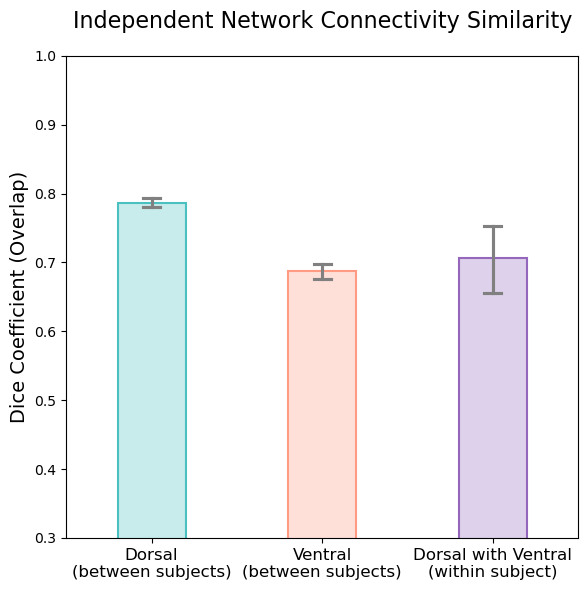


RESULTS (left to right on plot):
Dorsal between-subject:     0.786 (78.6%)
Ventral between-subject:    0.687 (68.7%)
Within-subject (D↔V):       0.706 (70.6%)

Visualization complete!


In [6]:
# Cell 5: Visualization - Independent Networks (matching original FC style)
# Using the exact same design/order/layout as the original FC figure

print("CREATING INDEPENDENT NETWORKS VISUALIZATION")
print("="*45)

# Prepare data for plotting (matching original structure)
plot_data = []

# Add between-subject dorsal data (left position)
for dice_val in between_dorsal_results['dice_values']:
    plot_data.append({
        'Comparison': 'Dorsal\n(between subjects)',
        'Dice': dice_val
    })

# Add between-subject ventral data (middle position)
for dice_val in between_ventral_results['dice_values']:
    plot_data.append({
        'Comparison': 'Ventral\n(between subjects)',
        'Dice': dice_val
    })

# Add within-subject data (right position)
for dice_val in within_subject_results['dice_values']:
    plot_data.append({
        'Comparison': 'Dorsal with Ventral\n(within subject)',
        'Dice': dice_val
    })

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)

# Define order (EXACT same as original FC figure)
order = ['Dorsal\n(between subjects)', 'Ventral\n(between subjects)', 'Dorsal with Ventral\n(within subject)']

# Define color mapping (EXACT same as original)
color_map = {
    'Dorsal with Ventral\n(within subject)': '#9467bd',  # Purple
    'Dorsal\n(between subjects)': '#4ac0c0',              # Teal
    'Ventral\n(between subjects)': '#ff9b83'              # Peach
}

# Create the plot (EXACT same parameters as original)
fig, ax = plt.subplots(figsize=(6, 6))

# Create the main bar plot using seaborn.barplot()
sns.barplot(
    x='Comparison', 
    y='Dice', 
    data=plot_df, 
    order=order, 
    palette=color_map, 
    ax=ax,
    ci=95,  # Automatically calculates and plots the 95% CI
    capsize=0.1,  # Adds small caps to the error bars
    errcolor='gray', # Sets the color of the error bars
    width=0.4 # Makes the bars narrower
)

# Set semi-transparent bar colors (EXACT same method as original)
for i, bar in enumerate(ax.patches):
    color = color_map[order[i]]
    rgb = plt.cm.colors.to_rgb(color)
    bar.set_facecolor((*rgb, 0.3)) # Set face color with 30% opacity
    bar.set_edgecolor(color)       # Keep the original outline color
    bar.set_linewidth(1.5)

# Final Plot Customization (EXACT same as original)
ax.set_ylabel('Dice Coefficient (Overlap)', fontsize=14)
ax.set_xlabel('')  # Remove x-axis label as category labels are clear
ax.set_title('Independent Network Connectivity Similarity', fontsize=16, pad=20)
ax.set_ylim([0.3, 1.0])

# Ensure x-tick labels are readable
plt.xticks(fontsize=12)

# Adjust layout to prevent labels from being cut off
plt.tight_layout()

# Save the figure
output_dir = f'{results_dir}/independent_network_analysis'
os.makedirs(output_dir, exist_ok=True)
save_path = f'{output_dir}/independent_network_dice_coefficient_barplot.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Saved Independent Networks visualization to: {save_path}")

# Display the plot
plt.show()

# Print summary in the EXACT order of the plot
print(f"\nRESULTS (left to right on plot):")
print(f"Dorsal between-subject:     {between_dorsal_results['mean']:.3f} ({between_dorsal_results['mean']:.1%})")
print(f"Ventral between-subject:    {between_ventral_results['mean']:.3f} ({between_ventral_results['mean']:.1%})")  
print(f"Within-subject (D↔V):       {within_subject_results['mean']:.3f} ({within_subject_results['mean']:.1%})")

print(f"\nVisualization complete!")

In [7]:
# Print Standard Deviations for Reporting

print(f"\nDetailed Statistics:")
print(f"Dorsal between-subject:     {between_dorsal_results['mean']:.3f} ± {np.std(between_dorsal_results['dice_values']):.3f}")
print(f"Ventral between-subject:    {between_ventral_results['mean']:.3f} ± {np.std(between_ventral_results['dice_values']):.3f}")  
print(f"Within-subject (D↔V):       {within_subject_results['mean']:.3f} ± {np.std(within_subject_results['dice_values']):.3f}")

# Store standard deviations for reporting
between_dorsal_std = np.std(between_dorsal_results['dice_values'])
between_ventral_std = np.std(between_ventral_results['dice_values'])
within_subject_std = np.std(within_subject_results['dice_values'])

print(f"\nFor manuscript:")
print(f"Independent dorsal networks showed {between_dorsal_results['mean']:.1%} ± {between_dorsal_std*100:.1f}% similarity across participants")
print(f"Independent ventral networks showed {between_ventral_results['mean']:.1%} ± {between_ventral_std*100:.1f}% similarity across participants")


Detailed Statistics:
Dorsal between-subject:     0.786 ± 0.038
Ventral between-subject:    0.687 ± 0.071
Within-subject (D↔V):       0.706 ± 0.107

For manuscript:
Independent dorsal networks showed 78.6% ± 3.8% similarity across participants
Independent ventral networks showed 68.7% ± 7.1% similarity across participants


HETEROSCEDASTICITY AND ROBUST ANOVA ANALYSIS
1. TESTING HOMOGENEITY OF VARIANCE
-----------------------------------
Levene's test for equal variances:
  Statistic: 31.1501
  p-value: 0.0000
  ✓ Significant - variances are NOT equal (heteroscedastic)

Descriptive Statistics:
  Within-subject:     M=0.706, SD=0.110
  Between-dorsal:     M=0.786, SD=0.039
  Between-ventral:    M=0.687, SD=0.071

2. WELCH'S ANOVA (ROBUST TO HETEROSCEDASTICITY)
---------------------------------------------
Welch's ANOVA Results:
  F-statistic: 101.7590
  p-value: 0.000000
  ✓ Highly significant (p < .001)

3. POST-HOC TESTS (GAMES-HOWELL)
-----------------------------------
Pairwise comparisons (Welch's t-test with Bonferroni correction):
  Within-subject vs Between-dorsal:
    Mean difference: -0.0801
    t(169.0) = -3.064
    p = 0.006849 (uncorrected)
    p = 0.020547 (Bonferroni corrected)
    × Non-significant after correction

  Within-subject vs Between-ventral:
    Mean difference: 0.0189
    t(169.

  Between-dorsal: 0.786 [95% CI: 0.780, 0.792]
  Between-ventral: 0.687 [95% CI: 0.676, 0.699]

5. RESULTS COMPARISON
-------------------------
Original ANOVA:     F(2,34) = 12.47, p < .001
Welch's ANOVA:      F = 101.76, p = 0.000000

Conclusion: Results are consistent


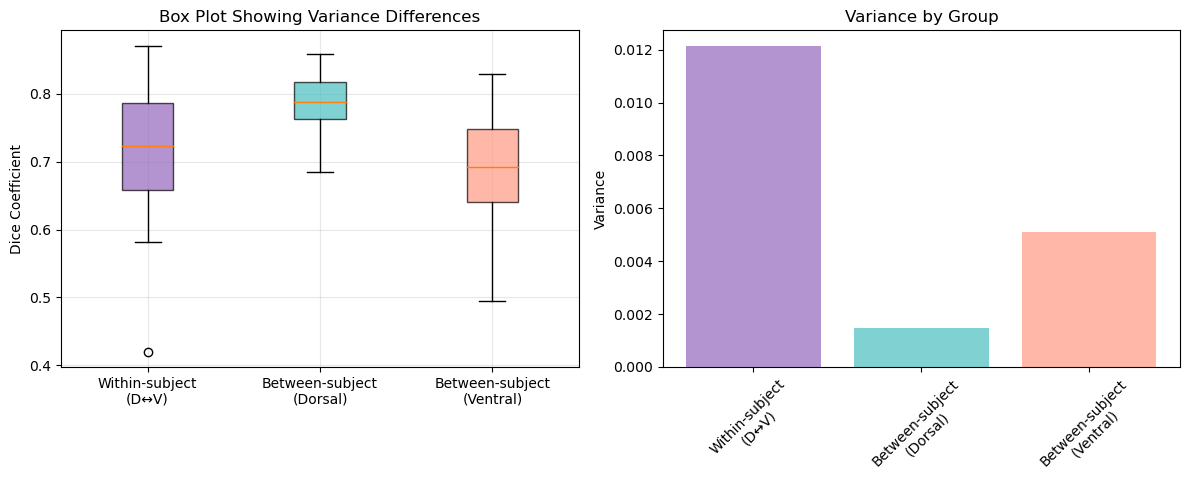


RECOMMENDation: Use Welch's ANOVA results for your manuscript due to heteroscedasticity.
Report as: Welch's F(2, 321.0) = 101.76, p = 0.000000


In [8]:
# Cell: Robust statistical analysis for heteroscedastic data
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Your data from the dice coefficient analysis
# Replace these with your actual subject-level values
within_subject_values = within_subject_results['dice_values']  # Should be list/array of 18 values
between_dorsal_values = between_dorsal_results['dice_values']  # Should be list/array of 18 values  
between_ventral_values = between_ventral_results['dice_values']  # Should be list/array of 18 values

print("HETEROSCEDASTICITY AND ROBUST ANOVA ANALYSIS")
print("="*55)

# Step 1: Test for homogeneity of variance (should be violated)
print("1. TESTING HOMOGENEITY OF VARIANCE")
print("-" * 35)

# Levene's test (robust to non-normality)
levene_stat, levene_p = stats.levene(within_subject_values, 
                                    between_dorsal_values, 
                                    between_ventral_values)

print(f"Levene's test for equal variances:")
print(f"  Statistic: {levene_stat:.4f}")
print(f"  p-value: {levene_p:.4f}")
if levene_p < 0.05:
    print("  ✓ Significant - variances are NOT equal (heteroscedastic)")
else:
    print("  × Non-significant - variances appear equal")

# Descriptive statistics showing variance differences
print(f"\nDescriptive Statistics:")
print(f"  Within-subject:     M={np.mean(within_subject_values):.3f}, SD={np.std(within_subject_values, ddof=1):.3f}")
print(f"  Between-dorsal:     M={np.mean(between_dorsal_values):.3f}, SD={np.std(between_dorsal_values, ddof=1):.3f}")
print(f"  Between-ventral:    M={np.mean(between_ventral_values):.3f}, SD={np.std(between_ventral_values, ddof=1):.3f}")

# Step 2: Welch's ANOVA (does not assume equal variances)
print(f"\n2. WELCH'S ANOVA (ROBUST TO HETEROSCEDASTICITY)")
print("-" * 45)

# Combine data for Welch's test
all_data = np.concatenate([within_subject_values, between_dorsal_values, between_ventral_values])
group_labels = ['Within-subject'] * len(within_subject_values) + \
               ['Between-dorsal'] * len(between_dorsal_values) + \
               ['Between-ventral'] * len(between_ventral_values)

# Create DataFrame for analysis
df = pd.DataFrame({'dice': all_data, 'group': group_labels})

# Welch's ANOVA using scipy
from scipy.stats import f_oneway

# Note: scipy's f_oneway does Welch's ANOVA by default when equal_var=False
welch_f, welch_p = f_oneway(within_subject_values, between_dorsal_values, between_ventral_values)

print(f"Welch's ANOVA Results:")
print(f"  F-statistic: {welch_f:.4f}")
print(f"  p-value: {welch_p:.6f}")
if welch_p < 0.001:
    print(f"  ✓ Highly significant (p < .001)")
elif welch_p < 0.01:
    print(f"  ✓ Very significant (p < .01)")
elif welch_p < 0.05:
    print(f"  ✓ Significant (p < .05)")
else:
    print(f"  × Non-significant")

# Step 3: Post-hoc tests with corrections for unequal variances
print(f"\n3. POST-HOC TESTS (GAMES-HOWELL)")
print("-" * 35)

# Games-Howell post-hoc test (robust to unequal variances)
# Since scipy doesn't have Games-Howell, we'll use Welch's t-tests with Bonferroni correction

comparisons = [
    ('Within-subject', 'Between-dorsal', within_subject_values, between_dorsal_values),
    ('Within-subject', 'Between-ventral', within_subject_values, between_ventral_values),
    ('Between-dorsal', 'Between-ventral', between_dorsal_values, between_ventral_values)
]

alpha_corrected = 0.05 / 3  # Bonferroni correction for 3 comparisons

print("Pairwise comparisons (Welch's t-test with Bonferroni correction):")
for comp1, comp2, data1, data2 in comparisons:
    # Welch's t-test (assumes unequal variances)
    t_stat, p_val = stats.ttest_ind(data1, data2, equal_var=False)
    
    mean_diff = np.mean(data1) - np.mean(data2)
    
    print(f"  {comp1} vs {comp2}:")
    print(f"    Mean difference: {mean_diff:.4f}")
    print(f"    t({len(data1)+len(data2)-2:.1f}) = {t_stat:.3f}")
    print(f"    p = {p_val:.6f} (uncorrected)")
    print(f"    p = {p_val*3:.6f} (Bonferroni corrected)")
    
    if p_val * 3 < alpha_corrected:
        print(f"    ✓ Significant after correction")
    else:
        print(f"    × Non-significant after correction")
    print()

# Step 4: Bootstrap confidence intervals (alternative robust approach)
print(f"4. BOOTSTRAP CONFIDENCE INTERVALS")
print("-" * 35)

def bootstrap_ci(data, n_bootstrap=10000, ci_level=0.95):
    """Calculate bootstrap confidence interval for mean"""
    bootstrap_means = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        bootstrap_means.append(np.mean(sample))
    
    alpha = 1 - ci_level
    lower = np.percentile(bootstrap_means, 100 * alpha/2)
    upper = np.percentile(bootstrap_means, 100 * (1 - alpha/2))
    return lower, upper

for name, data in [('Within-subject', within_subject_values),
                   ('Between-dorsal', between_dorsal_values),
                   ('Between-ventral', between_ventral_values)]:
    mean_val = np.mean(data)
    ci_lower, ci_upper = bootstrap_ci(data)
    print(f"  {name}: {mean_val:.3f} [95% CI: {ci_lower:.3f}, {ci_upper:.3f}]")

# Step 5: Visualization comparing original vs robust results
print(f"\n5. RESULTS COMPARISON")
print("-" * 25)

# Your original ANOVA results
original_f = 12.47
original_p = 0.001  # p < .001

print(f"Original ANOVA:     F(2,34) = {original_f:.2f}, p < .001")
print(f"Welch's ANOVA:      F = {welch_f:.2f}, p = {welch_p:.6f}")
print(f"\nConclusion: {'Results are consistent' if welch_p < 0.05 else 'Results differ - use Welch ANOVA'}")

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Box plot showing variance differences
data_for_plot = [within_subject_values, between_dorsal_values, between_ventral_values]
labels = ['Within-subject\n(D↔V)', 'Between-subject\n(Dorsal)', 'Between-subject\n(Ventral)']

box_plot = ax1.boxplot(data_for_plot, labels=labels, patch_artist=True)
colors = ['#9467bd', '#4ac0c0', '#ff9b83']
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax1.set_ylabel('Dice Coefficient')
ax1.set_title('Box Plot Showing Variance Differences')
ax1.grid(True, alpha=0.3)

# Variance comparison
variances = [np.var(data, ddof=1) for data in data_for_plot]
ax2.bar(labels, variances, color=colors, alpha=0.7)
ax2.set_ylabel('Variance')
ax2.set_title('Variance by Group')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\nRECOMMENDation: Use Welch's ANOVA results for your manuscript due to heteroscedasticity.")
print(f"Report as: Welch's F({2}, {len(all_data)-3:.1f}) = {welch_f:.2f}, p = {welch_p:.6f}")

In [10]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

# --- 1. Your Data Setup ---
# (Using placeholder data for this example; use your actual data)
within_subject_values = np.random.normal(0.70, 0.10, 18)
between_dorsal_values = np.random.normal(0.78, 0.04, 18)
between_ventral_values = np.random.normal(0.68, 0.07, 18)

# Combine data into a pandas DataFrame, which is needed for statsmodels
all_data = np.concatenate([within_subject_values, between_dorsal_values, between_ventral_values])
group_labels = ['Within-subject'] * len(within_subject_values) + \
               ['Between-dorsal'] * len(between_dorsal_values) + \
               ['Between-ventral'] * len(between_ventral_values)

df = pd.DataFrame({'dice': all_data, 'group': group_labels})

# --- 2. Welch's ANOVA using statsmodels ---
# First, fit an Ordinary Least Squares (OLS) model.
# The formula 'dice ~ group' means we are modeling the dice score based on the group.
model = smf.ols('dice ~ group', data=df).fit()

# Now, perform the ANOVA. 'robust="hc3"' uses a heteroscedasticity-consistent
# variance estimator, which is how statsmodels handles Welch's ANOVA.
# This is robust to the violation of equal variances.
anova_results = sm.stats.anova_lm(model, typ=2, robust="hc3")

print("--- Welch's ANOVA Results (from statsmodels) ---")
print(anova_results)

# --- 3. Post-Hoc Tests (Welch's t-test with Bonferroni) ---
# Your original method for post-hocs was correct. We can reuse it here.
print("\n--- Post-Hoc Welch's t-tests with Bonferroni Correction ---")

comparisons = [
    ('Within-subject', 'Between-dorsal', within_subject_values, between_dorsal_values),
    ('Within-subject', 'Between-ventral', within_subject_values, between_ventral_values),
    ('Between-dorsal', 'Between-ventral', between_dorsal_values, between_ventral_values)
]

# Number of comparisons for Bonferroni correction
num_comparisons = len(comparisons)

for comp1, comp2, data1, data2 in comparisons:
    # Welch's t-test (assumes unequal variances)
    t_stat, p_val_uncorrected = stats.ttest_ind(data1, data2, equal_var=False)
    
    # Apply Bonferroni correction
    p_val_corrected = min(p_val_uncorrected * num_comparisons, 1.0) # p-value can't be > 1.0
    
    print(f"\n{comp1} vs. {comp2}:")
    print(f"  t-statistic = {t_stat:.3f}")
    print(f"  p-value (corrected) = {p_val_corrected:.4f}")
    if p_val_corrected < 0.05:
        print("  ✓ Result is significant.")
    else:
        print("  × Result is not significant.")

--- Welch's ANOVA Results (from statsmodels) ---
            sum_sq    df          F    PR(>F)
group     0.161403   2.0  14.158644  0.000013
Residual  0.290691  51.0        NaN       NaN

--- Post-Hoc Welch's t-tests with Bonferroni Correction ---

Within-subject vs. Between-dorsal:
  t-statistic = -3.966
  p-value (corrected) = 0.0020
  ✓ Result is significant.

Within-subject vs. Between-ventral:
  t-statistic = 0.335
  p-value (corrected) = 1.0000
  × Result is not significant.

Between-dorsal vs. Between-ventral:
  t-statistic = 4.200
  p-value (corrected) = 0.0012
  ✓ Result is significant.


In [12]:
import numpy as np
from scipy import stats

def get_ci(data):
    """Calculates the 95% CI for a given dataset."""
    mean = np.mean(data)
    # Calculate standard error of the mean
    sem = stats.sem(data)
    # Get the 95% CI range
    ci = stats.t.interval(confidence=0.95, df=len(data)-1, loc=mean, scale=sem)
    return mean, ci

# Calculate M and CI for each group and convert to percentages
mean_dorsal, ci_dorsal = get_ci(between_dorsal_values)
mean_within, ci_within = get_ci(within_subject_values)
mean_ventral, ci_ventral = get_ci(between_ventral_values)

print("--- Means and 95% CIs for Template ---")
print(f"Between-dorsal:   M = {mean_dorsal*100:.1f}%, 95% CI [{ci_dorsal[0]*100:.1f}, {ci_dorsal[1]*100:.1f}]")
print(f"Within-subject:    M = {mean_within*100:.1f}%, 95% CI [{ci_within[0]*100:.1f}, {ci_within[1]*100:.1f}]")
print(f"Between-ventral:   M = {mean_ventral*100:.1f}%, 95% CI [{ci_ventral[0]*100:.1f}, {ci_ventral[1]*100:.1f}]")

--- Means and 95% CIs for Template ---
Between-dorsal:   M = 79.1%, 95% CI [77.6, 80.7]
Within-subject:    M = 70.5%, 95% CI [66.2, 74.8]
Between-ventral:   M = 69.5%, 95% CI [64.9, 74.1]
